In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt


import os

import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import models, transforms

#import torch.optim as optim
from torch.optim import lr_scheduler

import pytorch_lightning as pl
from pytorch_lightning.metrics.classification import Accuracy, FBeta
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.loggers import WandbLogger
import wandb

from tqdm import trange

from PIL import Image
import skimage.io as skio
from sklearn.preprocessing import MultiLabelBinarizer

import pandas as pd
import seaborn as sns

#wandb.login()

In [2]:
d = pd.read_csv("/home/ubuntu/data/sample_sparse_encodings.csv")
d.head()

,Feature,Building,Forest,Grassland,House,Park,Parking,Pool,Railway,Residential,Road,Soccer,Water,Wood
0,Z33-01331332121202132_062d02be-3a17-4129-82a2-...,1,0,0,0,0,1,0,1,0,1,0,1,1
1,Z33-01331332103102210_062d02be-3a17-4129-82a2-...,1,1,1,1,0,1,0,0,1,1,1,0,0
2,Z33-01331332032132023_06480218-b97f-4761-ab0f-...,0,0,0,1,0,0,0,0,1,1,0,1,0
3,Z33-01331332120131001_10400100549CFC00.jpg,1,0,0,0,0,1,0,0,1,1,1,0,1
4,Z33-01331332120101122_062d02be-3a17-4129-82a2-...,0,0,0,0,0,1,0,1,1,1,0,0,0


In [3]:
classes = d.columns[1:].tolist()
classes

['Building',
 'Forest',
 'Grassland',
 'House',
 'Park',
 'Parking',
 'Pool',
 'Railway',
 'Residential',
 'Road',
 'Soccer',
 'Water',
 'Wood']

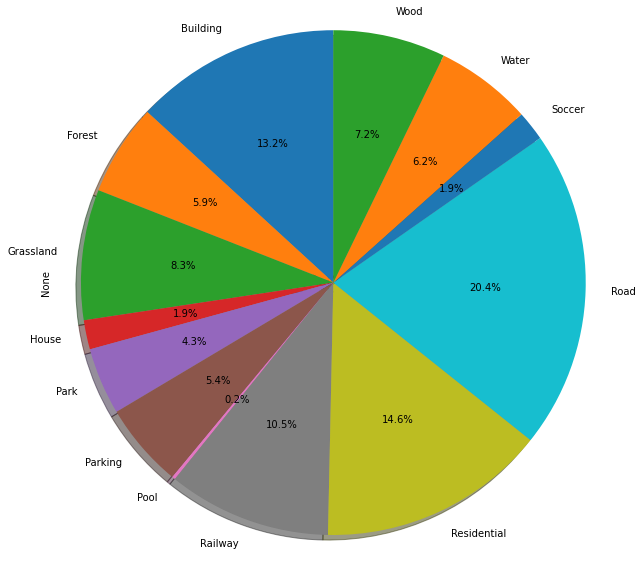

In [4]:
fig1, ax1 = plt.subplots(figsize=(10,10))
d.iloc[:,1:].sum(axis=0).plot.pie(autopct='%1.1f%%', shadow=True, startangle=90, ax=ax1)
ax1.axis("equal")
plt.show()

<AxesSubplot:>

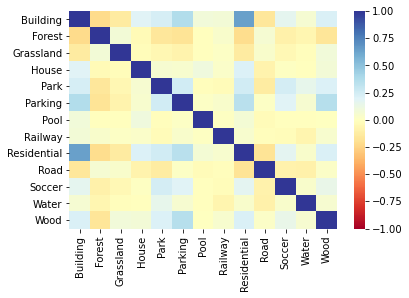

In [5]:
sns.heatmap(d.iloc[:,1:].corr(), cmap="RdYlBu", vmin=-1, vmax=1)

In [6]:
def visualize_image(idx, classes=classes):
    fd = d.iloc[idx]
    image = fd.Feature
    label = fd[1:].tolist()
    print(image)

    image = Image.open("/home/ubuntu/data/chips/" + image)
    #print(image.shape)
    fig, ax = plt.subplots(figsize=(10,10))
    ax.imshow(image)
    ax.grid(False)
    classes = np.array(classes)[np.array(label, dtype=np.bool)]
    for i, s in enumerate(classes):
        ax.text(0, i*20, s, verticalalignment='top', color='white', fontsize=16, weight='bold')
    plt.show()


Z33-01331332103300201_01280972-72af-433b-9b2c-cc71ec19614e-inv.jpg


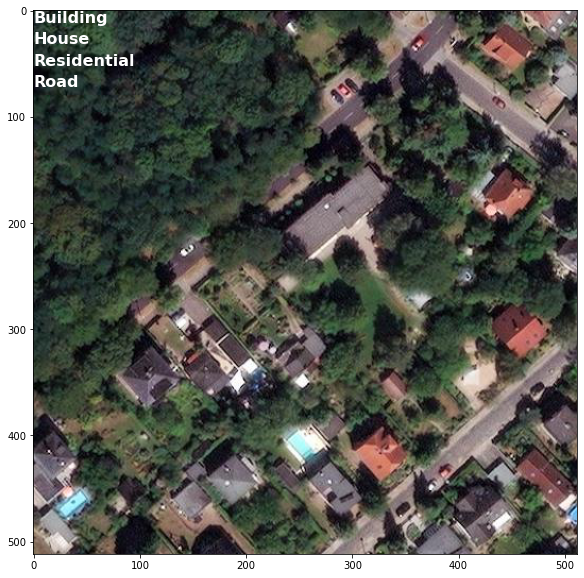

In [7]:
visualize_image(50)

In [8]:
LABELS_PATH = "/home/ubuntu/data/sample_sparse_encodings.csv"
IMAGES_DIR = "/home/ubuntu/data/chips"

MODEL_INPUT_IMAGE_SIZE = 256
BATCH_SIZE = 32

chip_size = MODEL_INPUT_IMAGE_SIZE



train_transform = transforms.Compose([
    transforms.Resize(chip_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


eval_transform = transforms.Compose([
    transforms.Resize(chip_size),
#    transforms.RandomRotation(45)
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])



class SkywayDataset(Dataset):

    def __init__(self, csv_file, img_dir, transforms=None):
        self.df = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transforms = transforms
        
#     @property
#     def transforms(self):
#         return self._transforms
    
#     @transforms.setter
#     def transforms(self, target_transforms):
#         self._transforms = target_transforms
        
    def __getitem__(self, idx):
        d = self.df.iloc[idx]
        image = Image.open(os.path.join(self.img_dir, d.Feature)).convert("RGB")
        label = torch.tensor(d[1:].tolist(), dtype = torch.float32)
        
        if self.transforms is not None:
            image = self.transforms(image)
        
        return image, label
    
    def __len__(self):
        return len(self.df)
    

class SkywayDataMolule(pl.LightningDataModule):
    
    skyway_transforms = {
        'training': train_transform,
        'validation': eval_transform,
        'testing': eval_transform        
    }
    
    def __init__(self, 
                 labels_path: str = LABELS_PATH, 
                 images_dir: str = IMAGES_DIR,
                 batch_size: int = BATCH_SIZE,
                 val_percent: float = 0.2,
                 test_percent: float = 0.1
                 ):
        super().__init__()
        self.labels_path = labels_path
        self.images_dir = images_dir
        self.batch_size = batch_size
        self.val_percent = val_percent
        self.test_percent = test_percent
        
    def setup(self, stage=None):
        skyway_dataset = SkywayDataset(self.labels_path, self.images_dir, eval_transform)
        
        testing_size = int(len(skyway_dataset) * self.test_percent)
        validation_size = int(len(skyway_dataset) * self.val_percent)
        training_size = len(skyway_dataset) - (validation_size + testing_size)
        train_set, val_set, test_set = random_split(skyway_dataset, 
                                                    [training_size, 
                                                     validation_size, 
                                                     testing_size]
                                                   )
        self.training_set = train_set
        self.validation_set = val_set
        self.testing_set = test_set
        
        # Assign appropriate transforms here
        # self.training_set.transforms = self.skyway_transforms['training']
        # self.validation_set.transforms = self.skyway_transforms['validation']
        # self.testing_set.transforms = self.skyway_transforms['testing']            
            
    def train_dataloader(self):
        loader = DataLoader(self.training_set, 
                            shuffle=True, 
                            batch_size=self.batch_size)
        return loader
    
    def val_dataloader(self):
        loader = DataLoader(self.validation_set, 
                            shuffle=False, 
                            batch_size=self.batch_size)
        return loader
    
    def test_dataloader(self):
        loader = DataLoader(self.testing_set,
                            shuffle=False,
                            batch_size=self.batch_size)
        return loader
        
            
    

class SkywayMuliLabelClassifier(pl.LightningModule):
    """
    A pytorch_lightning.LightningModule subclass. Used in 
    conjunction with SkywayDataset dataloader class for training,
    validating and testing multi-label, multi-class skyway data.
    """
    

    
    def __init__(self,
                 n_labels: int = 13,
                 cnn_backbone: nn.Module = models.resnet50,
                 loss_fn: nn.Module = nn.BCEWithLogitsLoss(),
                 discriminator_optimizer = torch.optim.Adam,
                 learning_rate: float = 1e-3,
                 discriminator_scheduler = lr_scheduler.CosineAnnealingLR,
                 binary_threshold = 0.5,
                ):
                  
        super().__init__()
        
        self.n_labels = n_labels
        self.loss = loss_fn
        self.optimizer = discriminator_optimizer
        self.learning_rate = learning_rate
        self.scheduler = discriminator_scheduler
        self.binary_threshold = binary_threshold
        self.cnn = cnn_backbone(pretrained=True)
        # Freeze backbone
        for param in self.cnn.parameters():
            param.requires_grad_(False)
            
        self.cnn.fc = nn.Sequential(
            nn.Linear(self.cnn.fc.in_features, self.cnn.fc.in_features // 2),
            nn.ReLU(),
            nn.BatchNorm1d(self.cnn.fc.in_features // 2),
            nn.Dropout(0.2),
            nn.Linear(self.cnn.fc.in_features // 2, self.cnn.fc.in_features // 4),
            nn.ReLU(),
            nn.BatchNorm1d(self.cnn.fc.in_features // 4),
            nn.Dropout(0.2),
            nn.Linear(self.cnn.fc.in_features // 4, self.n_labels)
        )
        
        # Set up metrics
        self.accuracy = Accuracy(threshold=self.binary_threshold,
                                 compute_on_step=True,
                                 dist_sync_on_step=True,
                                )
        self.f2 = FBeta(self.n_labels,
                        beta=2.0,
                        threshold=self.binary_threshold,
                        multilabel=True,
                        compute_on_step=True,
                        dist_sync_on_step=True,
                       )
        
    def forward(self, x):
        return self.cnn(x)
        
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)

        return {
            "y_hat": y_hat,
            "target": y
        }
    
    def training_step_end(self, outputs):
        y_hats = outputs['y_hat']
        targets = outputs['target']
        logits = torch.sigmoid(y_hats)
        
        loss = self.loss(y_hats, targets)
        accuracy = self.accuracy(logits, targets)
        f2 = self.f2(logits, targets)
        
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_acc', accuracy, prog_bar=True)
        self.log('train_f2', f2, prog_bar=True)
        
        return loss
        
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)

        return {
            "y_hat": y_hat,
            "target": y
        }
    
    def validation_step_end(self, outputs):
        y_hats = outputs['y_hat']
        targets = outputs['target']
        
        logits = torch.sigmoid(y_hats)
        
        loss = self.loss(y_hats, targets)
        accuracy = self.accuracy(logits, targets)
        f2 = self.f2(logits, targets)
        
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', accuracy, prog_bar=True)
        self.log('val_f2', f2, prog_bar=True)
        
        return loss
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)

        return {
            "y_hat": y_hat,
            "target": y
        }
    
    def test_step_end(self, outputs):
        y_hats = outputs['y_hat']
        targets = outputs['target']
        
        logits = torch.sigmoid(y_hats)
        
        loss = self.loss(y_hats, targets)
        accuracy = self.accuracy(logits, targets)
        f2 = self.f2(logits, targets)
        
        self.log('test_loss', loss, prog_bar=True)
        self.log('test_acc', accuracy, prog_bar=True)
        self.log('test_f2', f2, prog_bar=True)
        
        return loss
        
    def configure_optimizers(self):
        disc_optimizer = self.optimizer(self.cnn.parameters(), lr=self.learning_rate)
        disc_scheduler = self.scheduler(disc_optimizer, T_max=5, eta_min=0.005)
        return {
            "optimizer": disc_optimizer, 
            "lr_scheduler": disc_scheduler
        }        


In [9]:
seed_everything(42)


datamod = SkywayDataMolule()
model = SkywayMuliLabelClassifier()

datamod.setup("train")

#wandb_logger = WandbLogger(project="Imagesim", job_type="train")

trainer = Trainer(
#    logger=wandb_logger,
    gpus=-1,
    max_epochs=10,
    progress_bar_refresh_rate=20,
    accelerator='dp'
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


In [ ]:
trainer.fit(model, datamod)
#wandb.finish()


  | Name     | Type              | Params
-----------------------------------------------
0 | loss     | BCEWithLogitsLoss | 0     
1 | cnn      | ResNet            | 26.1 M
2 | accuracy | Accuracy          | 0     
3 | f2       | FBeta             | 0     
/home/ubuntu/anaconda3/envs/model/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/home/ubuntu/anaconda3/envs/model/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


In [14]:
def save_model(model, fname):
    batch_size = 32
    sample_input = torch.randn(batch_size, 3, 256, 256, device='cuda:0')
    model.to('cuda:0')
    torch.onnx.export(model, sample_input, fname, input_names=['input_batch'], output_names=['output_encodings'])

In [15]:
save_model(model, "model.onnx")